In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import os 
import imageio as iio
from scipy.signal import butter, lfilter
import scipy.signal as signal
import pickle
# from pyVHR.BVP.methods import cpu_CHROM, cpu_GREEN, cpu_POS, cpu_ICA, cpu_SSR

c:\Users\111\.conda\envs\mm_p\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\111\.conda\envs\mm_p\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
c:\Users\111\.conda\envs\mm_p\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
video_root_path = r"C:\Users\Adnan\Downloads\syndicate_test"
NIR1 = "NIR_Camera"
NIR2 = "NIR_Vimba_Camera"
RGB  = "RGB"

In [3]:
def collect_video(folder_path, str_id, file_type=".bmp"):
    dir_list = os.listdir(folder_path)
    img_files = [i for i in dir_list if str_id in i and file_type in i]
    imgs = []
    for i in range(len(img_files)):
        img_path = os.path.join(folder_path, str_id+"_"+str(i)+file_type)
        imgs.append(iio.imread(img_path))
    
    return np.array(imgs)

def crop_video(frames, coord, dx, dy):
    return frames[:,coord[0]:coord[0]+dx, coord[1]:coord[1]+dy]

def butter_bandpass(lowcut=55/60, highcut=150/60, fs=30, order=5):
    return butter(order, [lowcut, highcut], fs=fs, btype='band')

def butter_bandpass_filter(data, lowcut=55/60, highcut=150/60, fs=30, order=7):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    data = data * np.hanning(len(data))
    y = lfilter(b, a, data)
    return y

def hr_est(sig, fps=30, vis=False):
    sig_f = np.abs(np.fft.fft(sig))
    sig_f[int(len(sig_f)/2):] = 0
    bpm = np.argmax(sig_f) / len(sig) * fps * 60
    max_amp = np.max(sig_f)
    if(vis):
        freqs = np.fft.fftfreq(len(sig), d=1/fps)*60
        upper_bound = int(200/60/(fps/len(sig)))
        plt.figure()
        plt.plot(freqs[0:upper_bound], sig_f[0:upper_bound])
    return bpm, max_amp 


In [4]:
##Label peaks
from scipy.sparse import spdiags

def custom_detrend(signal, Lambda):
    """custom_detrend(signal, Lambda) -> filtered_signal
    This function applies a detrending filter.
    This code is based on the following article "An advanced detrending method with application
    to HRV analysis". Tarvainen et al., IEEE Trans on Biomedical Engineering, 2002.
    *Parameters*
      ``signal`` (1d numpy array):
        The signal where you want to remove the trend.
      ``Lambda`` (int):
        The smoothing parameter.
    *Returns*
      ``filtered_signal`` (1d numpy array):
        The detrended signal.
    """
    signal_length = signal.shape[0]

    # observation matrix
    H = np.identity(signal_length)

    # second-order difference matrix

    ones = np.ones(signal_length)
    minus_twos = -2 * np.ones(signal_length)
    diags_data = np.array([ones, minus_twos, ones])
    diags_index = np.array([0, 1, 2])
    D = spdiags(diags_data, diags_index, (signal_length - 2), signal_length).toarray()
    filtered_signal = np.dot((H - np.linalg.inv(H + (Lambda ** 2) * np.dot(D.T, D))), signal)
    return filtered_signal

def pulse_rate_from_power_spectral_density(pleth_sig: np.array, FS: float,
                                           LL_PR: float, UL_PR: float,
                                           BUTTER_ORDER: int = 6,
                                           DETREND: bool = False,
                                           FResBPM: float = 0.1) -> float:
    """ Function to estimate the pulse rate from the power spectral density of the plethysmography signal.
    Args:
        pleth_sig (np.array): Plethysmography signal.
        FS (float): Sampling frequency.
        LL_PR (float): Lower cutoff frequency for the butterworth filtering.
        UL_PR (float): Upper cutoff frequency for the butterworth filtering.
        BUTTER_ORDER (int, optional): Order of the butterworth filter. Give None to skip filtering. Defaults to 6.
        DETREND (bool, optional): Boolena Flag for executing cutsom_detrend. Defaults to False.
        FResBPM (float, optional): Frequency resolution. Defaults to 0.1.
    Returns:
        pulse_rate (float): _description_
    
    Daniel McDuff, Ethan Blackford, January 2019
    Copyright (c)
    Licensed under the MIT License and the RAIL AI License.
    """

    N = (60*FS)/FResBPM

    # Detrending + nth order butterworth + periodogram
    if DETREND:
        pleth_sig = custom_detrend(np.cumsum(pleth_sig), 100)
    if BUTTER_ORDER:
        if(LL_PR == 0):
            [b, a] = signal.butter(BUTTER_ORDER, UL_PR/60, btype='lowpass', fs = FS)
        else:
            [b, a] = signal.butter(BUTTER_ORDER, [LL_PR/60, UL_PR/60], btype='bandpass', fs = FS)
    
    pleth_sig = signal.filtfilt(b, a, np.double(pleth_sig))
    
    # Calculate the PSD and the mask for the desired range
    F, Pxx = signal.periodogram(x=pleth_sig,  nfft=N, fs=FS);  
    FMask = (F >= (LL_PR/60)) & (F <= (UL_PR/60))
    
    # Calculate predicted pulse rate:
    FRange = F * FMask
    PRange = Pxx * FMask
    MaxInd = np.argmax(PRange)
    pulse_rate_freq = FRange[MaxInd]
    pulse_rate = pulse_rate_freq*60
            
    return pulse_rate, pleth_sig

#Plot vector
def plot_vector(vec):
    plt.figure()
    plt.plot(vec)
    plt.show()

def find_peaks(signal,left_off,right_off, plotVar=False, printVar=False):
    right_off = right_off+1

    sig_l = len(signal)

    peaks = []

    for i in range(sig_l):
        if i!=0 and i!=sig_l-1: #If peak is first or last element, dont add
            tmp_l_ix = np.maximum(0,i-left_off)
            tmp_r_ix = np.minimum(sig_l,i+right_off)
            tmp_rel_ix = i-tmp_l_ix

            if np.argmax(signal[tmp_l_ix:tmp_r_ix])==tmp_rel_ix:
                peaks.append(i)
            
    
            
    if plotVar:
        plt.figure()
        plt.plot(range(sig_l),signal)
        plt.plot(peaks,signal[peaks],'rx')
#         plt.xlim([250,300])
        plt.show()
        
    if printVar:
        print(peaks)

    return peaks


#for each peak find corresponding trough

def find_troughs(signal,peaks,left_off,right_off, plotVar=False, printVar=False):
    
    right_off = right_off+1
    sig_l = len(signal)
    
    troughs = []
    
    for pk in peaks:
        cur_ix = pk
        min_flag = 0
        
        while cur_ix<sig_l-1-1:
            cur_ix+=1
            tmp_l_ix = np.maximum(0,cur_ix-left_off)
            tmp_r_ix = np.minimum(sig_l,cur_ix+right_off)
            tmp_rel_ix = cur_ix-tmp_l_ix
            
            if np.argmin(signal[tmp_l_ix:tmp_r_ix])==tmp_rel_ix:
                troughs.append(cur_ix)
                break
                
    #CONSISTENCY CHECKS
    #1. If peaks>troughs
    #2. If particular trough is at extremes: fixed by changing while loop condition from 'cur_ix<=sig_l-1' to 'cur_ix<sig_l-1-1' 
    
    #Check 1.
    print(len(peaks),len(troughs))
    if len(peaks)>len(troughs): #Currently just considering the case where last trough is not found
        peaks = peaks[0:-1]
    
            
    if plotVar:
        plt.figure()
        plt.plot(range(sig_l),signal)
        plt.plot(troughs,signal[troughs],'gx')
#         plt.xlim([300,350])
        plt.show()
        
    if printVar:
        print(troughs)
    
    return troughs,peaks #returning refined peaks

def get_signal_amplitude(ac_signal, dc_signal, peaks, troughs):
    high = np.mean(ac_signal[peaks]/dc_signal[peaks])
    low = np.mean(ac_signal[troughs]/dc_signal[troughs])

    return (high-low),  (np.mean(ac_signal[peaks])-np.mean(ac_signal[troughs]))


def process_AC_HR_BPM(video_path, item_str, crop_center=(0,0), crop_delta=(100,100), file_type=".bmp"):
    nir_video = collect_video(video_path, item_str, file_type=file_type)
    if(len(nir_video.shape) == 4):
        nir_video = nir_video[:,:,:,2] #Red in RGB
    print(nir_video.shape)
    nir_cropped = crop_video(nir_video, crop_center,crop_delta[0],crop_delta[1])
    nir_temporal_mean = np.mean(nir_cropped, (1,2))

    hrOut, g_ac_ppg = pulse_rate_from_power_spectral_density(nir_temporal_mean, 30, 45, 200)
    _, g_dc_ppg = pulse_rate_from_power_spectral_density(nir_temporal_mean, 30, 0, 30)
    peaks = find_peaks(g_ac_ppg,10,7, plotVar=False, printVar=False)
    troughs,peaks = find_troughs(g_ac_ppg,peaks,10,7, plotVar=False, printVar=False)
    print(g_ac_ppg.shape, g_dc_ppg.shape)
    amp, amp_ac = get_signal_amplitude(g_ac_ppg, g_dc_ppg, peaks=peaks, troughs=troughs)
    print(f"{item_str}::: Estimated HR: {hrOut}, Estimated Amplitude: {amp}")

    return amp, amp_ac, hrOut, g_ac_ppg

def process_AC_HR_BPM_GT(video, item_str, gt_hr, bw, crop_center=(0,0), crop_delta=(100,100), file_type=".bmp"):
    if(len(nir_video.shape) == 4):
        nir_video = nir_video[:,:,:,2] #Red in RGB
    print(nir_video.shape)
    nir_cropped = crop_video(nir_video, crop_center,crop_delta[0],crop_delta[1])
    nir_temporal_mean = np.mean(nir_cropped, (1,2))

    hrOut, g_ac_ppg = pulse_rate_from_power_spectral_density(nir_temporal_mean, gt_hr-bw, gt_hr+bw, 200)
    _, g_dc_ppg = pulse_rate_from_power_spectral_density(nir_temporal_mean, 30, 0, 30)
    peaks = find_peaks(g_ac_ppg,10,7, plotVar=False, printVar=False)
    troughs,peaks = find_troughs(g_ac_ppg,peaks,10,7, plotVar=False, printVar=False)
    print(g_ac_ppg.shape, g_dc_ppg.shape)
    amp, amp_ac = get_signal_amplitude(g_ac_ppg, g_dc_ppg, peaks=peaks, troughs=troughs)
    print(f"{item_str}::: Estimated HR: {hrOut}, Estimated Amplitude: {amp}")

    return amp, amp_ac, hrOut, g_ac_ppg



In [236]:
# videos = []
# gt_spo2 = []

# min_id = 1
# max_id = 9
# str_id = 'r'
# a = [1,2,3,4,5,7,8,9,10]
# # for i in range(min_id, max_id+1):
# for i in a:
#     print(i)
#     video1 = collect_video(folder_path=os.path.join("D:\syndicate_tests", str_id +str(i), NIR1), str_id="img", file_type=".png")
#     video2 = collect_video(folder_path=os.path.join("D:\syndicate_tests", str_id+str(i), NIR2), str_id="img", file_type=".png") 
#     video3 = collect_video(folder_path=os.path.join("D:\syndicate_tests", str_id+str(i), "RGB"), str_id="img", file_type=".png") 

    
#     vital_dict_path = os.path.join("D:\syndicate_tests", str_id +str(i), "MX800", "vital_interpolated_dictionary.pkl")
#     fileObj = open(os.path.join(vital_dict_path), 'rb')
#     vital_dict = pickle.load(fileObj)
#     fileObj.close()

#     videos.append((video1, video2, video3[:,:,:,2], video3[:,:,:,1], video3[:,:,:,0]))
#     gt_spo2.append(vital_dict['NOM_PULS_OXIM_SAT_O2'])
import cv2
videos = []
gt_spo2 = []

min_id = 1
max_id = 9
str_id = 't'
a = [1,2,3,4,5,6,7,8,9,10]
# for i in range(min_id, max_id+1):
for i in a:
    print(i)
    video = []
    cap = cv2.VideoCapture(os.path.join("D:\syndicate_tests", str_id +str(i), "finger.mp4"))
    ret, frame = cap.read()
    while(ret):
        video.append(np.mean(frame, axis=(0,1)))
        ret, frame = cap.read()

    video=np.array(video)

    vital_dict_path = os.path.join("D:\syndicate_tests", str_id +str(i), "MX800", "vital_interpolated_dictionary.pkl")
    fileObj = open(os.path.join(vital_dict_path), 'rb')
    vital_dict = pickle.load(fileObj)
    fileObj.close()

    videos.append(video)
    gt_spo2.append(vital_dict['NOM_PULS_OXIM_SAT_O2'])


1
2
3
4
5
6
7
8
9


FileNotFoundError: [Errno 2] No such file or directory: 'D:\\syndicate_tests\\t9\\MX800\\vital_interpolated_dictionary.pkl'

In [235]:
len(gt_spo2)

7

In [287]:
window_length = 30*20 #10 seconds
window_step   = int(30*1) #5 seconds 
video_length = 1350
start_idxs = np.arange(0, video_length-window_length, step=window_step)
num_videos = len(videos)

ratios = []
gts = []
f_ratios = []
f_gts = []
total = 0 
failed = 0
# a = [1,2,3,4,7]
a = [0,1,2,3,4,5,7]
for i in a:
    for j in start_idxs:
        print(i,j)
        n1_m =videos[i][j:j+window_length,0]
        hrOut1, g_ac_ppg = pulse_rate_from_power_spectral_density(n1_m, 30, 45, 200)
        _, g_dc_ppg = pulse_rate_from_power_spectral_density(n1_m, 30, 0, 30)
        peaks = find_peaks(g_ac_ppg,10,7, plotVar=False, printVar=False)
        troughs,peaks = find_troughs(g_ac_ppg,peaks,10,7, plotVar=False, printVar=False)
        amp1, amp_ac1 = get_signal_amplitude(g_ac_ppg, g_dc_ppg, peaks=peaks, troughs=troughs)

        n2_m =videos[i][j:j+window_length,1]
        hrOut2, g_ac_ppg = pulse_rate_from_power_spectral_density(n2_m, 30, 45, 200)
        _, g_dc_ppg = pulse_rate_from_power_spectral_density(n2_m, 30, 0, 30)
        peaks = find_peaks(g_ac_ppg,10,7, plotVar=False, printVar=False)
        troughs,peaks = find_troughs(g_ac_ppg,peaks,10,7, plotVar=False, printVar=False)
        amp2, amp_ac2 = get_signal_amplitude(g_ac_ppg, g_dc_ppg, peaks=peaks, troughs=troughs)

        n3_m =videos[i][j:j+window_length,2]
        hrOut3, g_ac_ppg = pulse_rate_from_power_spectral_density(n3_m, 30, 45, 200)
        _, g_dc_ppg = pulse_rate_from_power_spectral_density(n3_m, 30, 0, 30)
        peaks = find_peaks(g_ac_ppg,10,7, plotVar=False, printVar=False)
        troughs,peaks = find_troughs(g_ac_ppg,peaks,10,7, plotVar=False, printVar=False)
        amp3, amp_ac3 = get_signal_amplitude(g_ac_ppg, g_dc_ppg, peaks=peaks, troughs=troughs)



        # if(np.abs(hrOut1-hrOut2) < 5):
        ratios.append((amp1,amp2,amp3))
        spo2_val = np.mean(gt_spo2[i][j:j+window_length])
        gts.append(spo2_val)
        print(f"Estimated HR: {hrOut1, hrOut2, hrOut3}, Estimated Amplitude: {amp1, amp2, amp3}, SpO2: {spo2_val}")
        total+=1

        if(np.abs(hrOut1-hrOut2) < 3 and np.abs(hrOut1-hrOut3) < 3 and np.abs(hrOut2-hrOut3) < 3 ):
            f_ratios.append((amp1,amp2,amp3))
            spo2_val = np.mean(gt_spo2[i][j:j+window_length])
            f_gts.append(spo2_val)
        else:
            failed +=1
        
        print(10*"-")
    print()
    print()
    print()

print(f"Total points: {total}, failed points: {failed}.")



0 0
29 28
28 27
28 27
Estimated HR: (82.5, 82.60000000000001, 82.60000000000001), Estimated Amplitude: (0.1634587575291345, 0.11743128210332171, 0.005677296379486479), SpO2: 98.39456629581461
----------
0 30
28 28
28 28
28 28
Estimated HR: (82.7, 82.7, 82.7), Estimated Amplitude: (0.17274458256304276, 0.12092831865270097, 0.005839286652513885), SpO2: 98.40684315103725
----------
0 60
29 28
28 27
28 27
Estimated HR: (82.60000000000001, 82.60000000000001, 82.60000000000001), Estimated Amplitude: (0.17258332256116848, 0.12505147640594216, 0.005942482220592975), SpO2: 98.41536656273065
----------
0 90
28 28
28 28
28 28
Estimated HR: (82.9, 82.9, 82.80000000000001), Estimated Amplitude: (0.1798084776055874, 0.13029035570848319, 0.006174526241042969), SpO2: 98.4109529489202
----------
0 120
28 27
27 27
27 27
Estimated HR: (86.6, 86.7, 86.6), Estimated Amplitude: (0.18448973983229727, 0.1364725603522044, 0.006416963264644645), SpO2: 98.39728064006816
----------
0 150
28 27
28 27
28 27
Estimat

## Get AC/DC Numbers and Ratios

In [288]:
from sklearn.linear_model import LinearRegression
from itertools import combinations
print(ratio_data.shape)

(245, 3)


[(0, 1), (0, 2), (1, 2)]
[-0.0266284] 94.48396342376228
Error: 3.1415764919127462
[-0.03945419] 96.63798622993629
Error: 3.2616010034817298
[-0.00517702] 95.1057128902236
Error: 3.1749728250103195


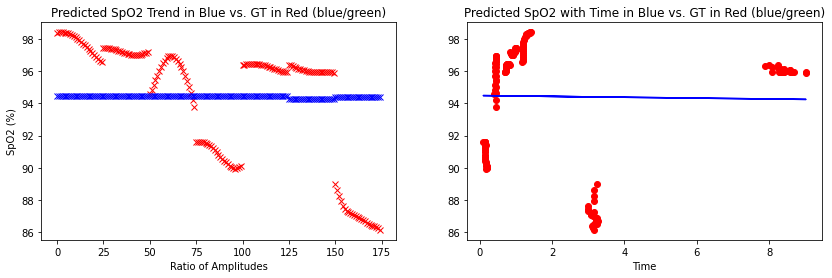

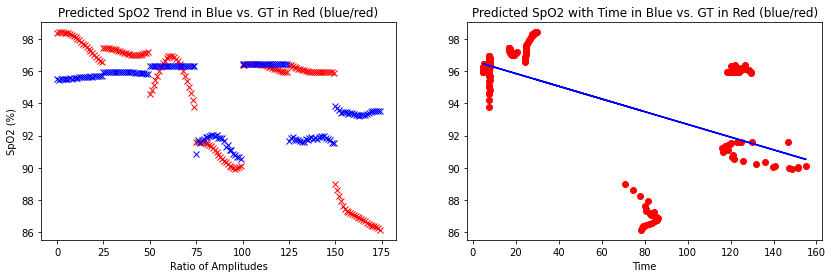

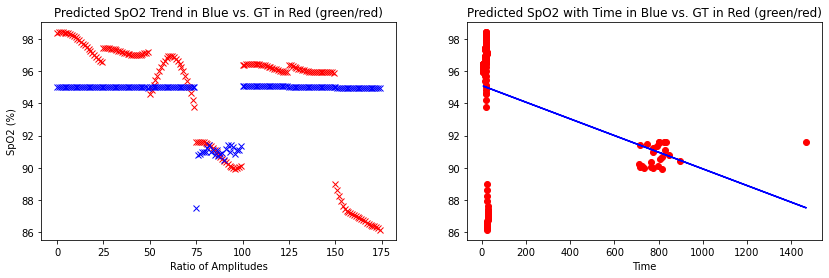

In [289]:
ratio_data = np.array(ratios)
L = [0,1,2]
RGB = ['blue', 'green', 'red']
cRGB = ['r','g','b']
pair_waves = [comb for comb in combinations(L, 2)]
print(pair_waves)
for i in pair_waves:
    n1n2_data = np.reshape(ratio_data[:,i[0]]/ratio_data[:,i[1]], newshape=[-1,1])
    reg = LinearRegression().fit(n1n2_data, gts)
    m1, b1 = reg.coef_, reg.intercept_
    print(m1, b1)

    plt.figure(figsize=(14,4))
    plt.subplot(1, 2, 1)
    plt.title(f"Predicted SpO2 Trend in Blue vs. GT in Red ({RGB[i[0]]}/{RGB[i[1]]})")
    plt.plot(gts, 'rx')
    plt.plot(m1*n1n2_data+b1, 'bx')
    plt.ylabel("SpO2 (%)")
    plt.xlabel("Ratio of Amplitudes")
    plt.subplot(1, 2, 2)
    plt.title(f"Predicted SpO2 with Time in Blue vs. GT in Red ({RGB[i[0]]}/{RGB[i[1]]})")
    plt.plot(n1n2_data, gts, 'o', color='red')
    plt.plot(n1n2_data, m1*n1n2_data+b1, color='blue')
    plt.xlabel("Time")
    r_error = np.mean(np.abs(gts - (m1*n1n2_data+b1)))
    print(f"Error: {r_error}")


[(0, 1), (0, 2), (1, 2)]
Coefficients: [-0.19934566] 95.55589686482757
MAE Error: 2.72933061916736


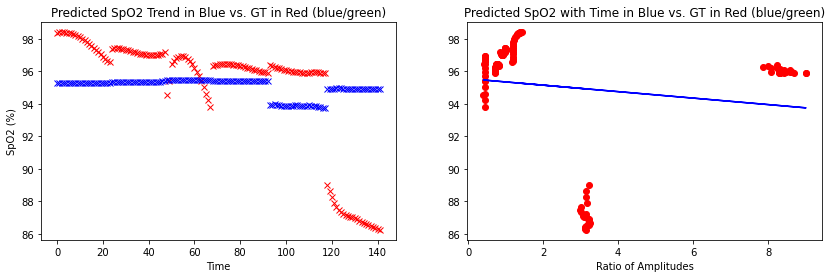

Coefficients: [-0.03384095] 96.56295485766422
MAE Error: 2.8231668667033345


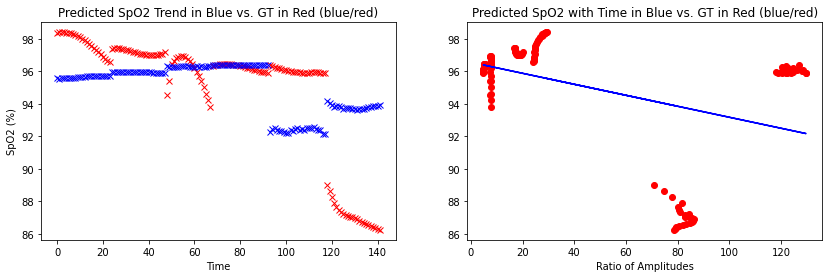

Coefficients: [-0.32470904] 100.66599173787503
MAE Error: 3.246915433096009


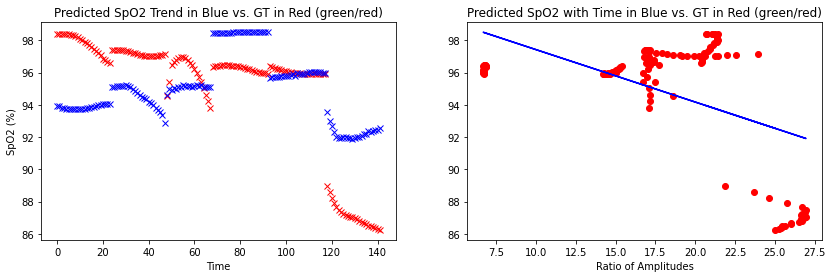

In [294]:
ratio_data = np.array(f_ratios)
L = [0,1,2]
RGB = ['blue', 'green', 'red']
pair_waves = [comb for comb in combinations(L, 2)]
print(pair_waves)
for i in pair_waves:
    n1n2_data = np.reshape(ratio_data[:,i[0]]/ratio_data[:,i[1]], newshape=[-1,1])
    reg = LinearRegression().fit(n1n2_data, f_gts)
    m1, b1 = reg.coef_, reg.intercept_
    print("Coefficients:", m1, b1)

    plt.figure(figsize=(14,4))
    plt.subplot(1, 2, 1)
    plt.title(f"Predicted SpO2 Trend in Blue vs. GT in Red ({RGB[i[0]]}/{RGB[i[1]]})")
    plt.plot(f_gts, 'rx')
    plt.plot(m1*n1n2_data+b1, 'bx')
    plt.ylabel("SpO2 (%)")
    plt.xlabel("Time")
    plt.subplot(1, 2, 2)
    plt.title(f"Predicted SpO2 with Time in Blue vs. GT in Red ({RGB[i[0]]}/{RGB[i[1]]})")
    plt.plot(n1n2_data, f_gts, 'o', color='red')
    plt.plot(n1n2_data, m1*n1n2_data+b1, color='blue')
    plt.xlabel("Ratio of Amplitudes")
    r_error = np.mean(np.abs(f_gts - (m1*n1n2_data+b1)))
    print(f"MAE Error: {r_error}")
    plt.show()


[(0, 1), (0, 2), (1, 2)]
[ 2.47380023 -0.17995461  0.0209929 ] 96.42748098803729
Error: 1.6973486628944143


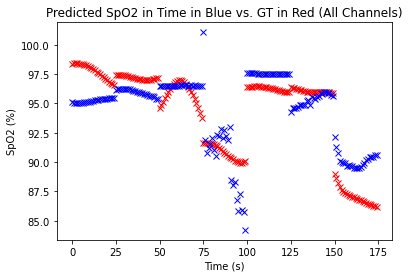

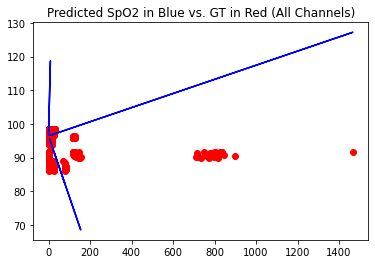

In [292]:
ratio_data = np.array(ratios)
L = [0,1,2]
RGB = ['blue', 'green', 'red']
cRGB = ['r','g','b']
pair_waves = [comb for comb in combinations(L, 2)]
print(pair_waves)

n1n2_data = np.array([ratio_data[:,0]/ratio_data[:,1], ratio_data[:,0]/ratio_data[:,2], ratio_data[:,1]/ratio_data[:,2]]).T
reg = LinearRegression().fit(n1n2_data, gts)
m1, b1 = reg.coef_, reg.intercept_
print(m1, b1)

plt.figure()
plt.title(f"Predicted SpO2 in Time in Blue vs. GT in Red (All Channels)")
plt.plot(gts, 'rx')
plt.plot(n1n2_data@m1+b1, 'bx')
plt.ylabel("SpO2 (%)")
plt.xlabel("Time (s)")

plt.figure()
plt.title(f"Predicted SpO2 in Blue vs. GT in Red (All Channels)")
plt.plot(n1n2_data, gts, 'o', color='red')
plt.plot(n1n2_data, m1*n1n2_data+b1, color='blue')
r_error = np.mean(np.abs(gts - (n1n2_data@m1+b1)))
print(f"Error: {r_error}")


## Ratio of Ratios Method with AC/DC

Error: 3.7624839515928636


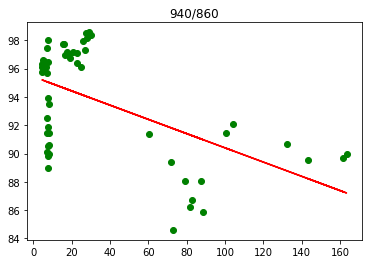

# Visualized Testing

In [134]:
test_name="d1"
folder_path1 = os.path.join(video_root_path, test_name, NIR1)
folder_path2 = os.path.join(video_root_path, test_name, NIR2)
folder_path3 = os.path.join(video_root_path, test_name, RGB)
nir1_video = collect_video(folder_path1, NIR1)
nir2_video = collect_video(folder_path2, NIR2)
rgb_video = collect_video(folder_path3, RGB, file_type=".png")



C:\Users\Adnan\AppData\Local\Temp\ipykernel_24340\4066593182.py:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  imgs.append(iio.imread(img_path))


In [135]:
print(nir1_video.shape, nir2_video.shape, rgb_video.shape)

(600, 2048, 2048) (600, 1944, 2592) (600, 480, 640, 3)


26 25
Estimated HR: 59.300000000000004, Estimated Amplitude: (0.0009680525244204461, 0.16276151033185116)


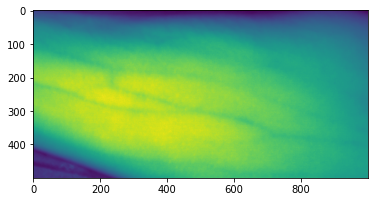

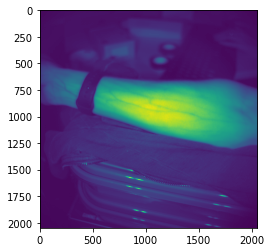

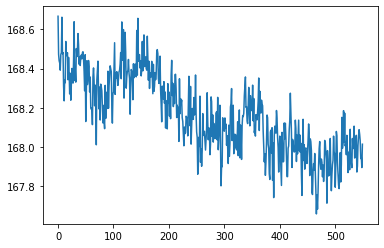

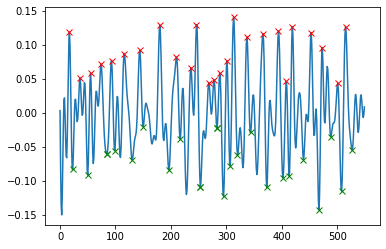

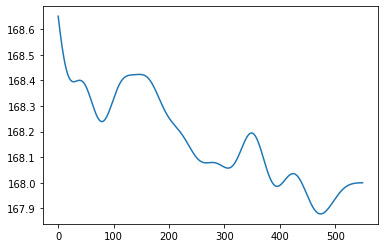

In [136]:
nir1_cropped = crop_video(nir1_video[50:], (650,800),500,1000)
plt.figure()
plt.imshow(nir1_cropped[0])
plt.figure()
plt.imshow(nir1_video[0])
nir1_temporal_mean = np.mean(nir1_cropped, (1,2))
hrOut, g_ac_ppg = pulse_rate_from_power_spectral_density(nir1_temporal_mean, 30, 45, 200)
_, g_dc_ppg = pulse_rate_from_power_spectral_density(nir1_temporal_mean, 30, 0, 30)
peaks = find_peaks(g_ac_ppg,10,7, plotVar=False, printVar=False)
troughs,peaks = find_troughs(g_ac_ppg,peaks,10,7, plotVar=False, printVar=False)
amp = get_signal_amplitude(g_ac_ppg, g_dc_ppg, peaks=peaks, troughs=troughs)
print(f"Estimated HR: {hrOut}, Estimated Amplitude: {amp}")

plt.figure()
plt.plot(nir1_temporal_mean)
plt.figure()
plt.plot(g_ac_ppg)
plt.plot(peaks,g_ac_ppg[peaks],'rx')
plt.plot(troughs,g_ac_ppg[troughs],'gx')
plt.figure()
plt.plot(g_dc_ppg)


27 27
Estimated HR: 58.6, Estimated Amplitude: (0.00027592790362668783, 0.05515811959130098)


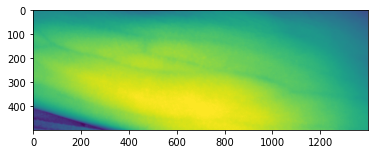

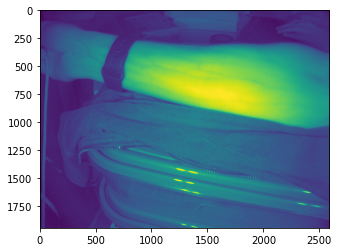

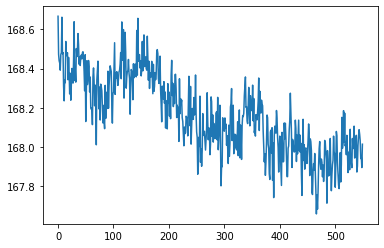

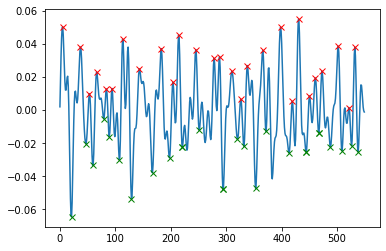

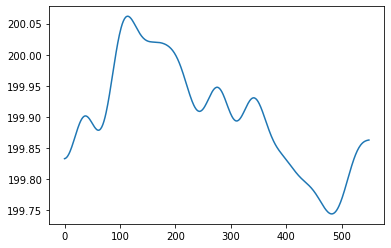

In [137]:
nir2_cropped = crop_video(nir2_video[50:], (350,950),500,1400)
plt.figure()
plt.imshow(nir2_cropped[0])
plt.figure()
plt.imshow(nir2_video[0])

nir2_temporal_mean = np.mean(nir2_cropped, (1,2))
hrOut, g_ac_ppg = pulse_rate_from_power_spectral_density(nir2_temporal_mean, 30, 45, 200)
_, g_dc_ppg = pulse_rate_from_power_spectral_density(nir2_temporal_mean, 30, 0, 30)
peaks = find_peaks(g_ac_ppg,10,7, plotVar=False, printVar=False)
troughs,peaks = find_troughs(g_ac_ppg,peaks,10,7, plotVar=False, printVar=False)
amp = get_signal_amplitude(g_ac_ppg, g_dc_ppg, peaks=peaks, troughs=troughs)
print(f"Estimated HR: {hrOut}, Estimated Amplitude: {amp}")

plt.figure()
plt.plot(nir1_temporal_mean)
plt.figure()
plt.plot(g_ac_ppg)
plt.plot(peaks,g_ac_ppg[peaks],'rx')
plt.plot(troughs,g_ac_ppg[troughs],'gx')
plt.figure()
plt.plot(g_dc_ppg)

In [138]:
rgb_video.shape

(600, 480, 640, 3)

16 14
Estimated HR: 55.7, Estimated Amplitude: (0.002376105858569351, 0.44582981699236907)


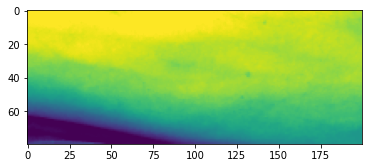

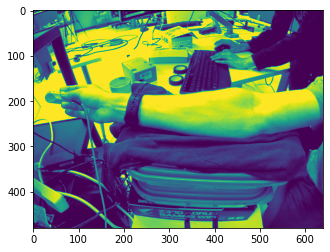

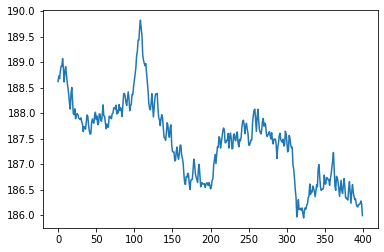

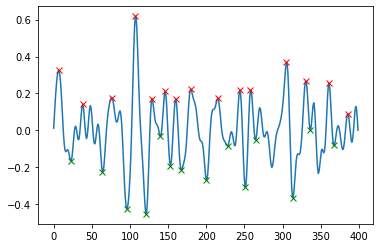

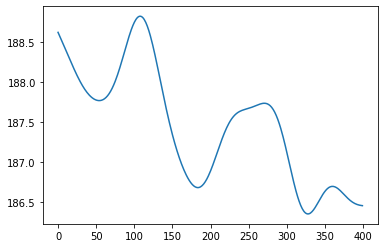

In [139]:
rgb_cropped = crop_video(rgb_video[200:,:,:,0], (195,250),80,200)
plt.figure()
plt.imshow(rgb_cropped[0])
plt.figure()
plt.imshow(rgb_video[0,:,:,0])

rgb_temporal_mean = np.mean(rgb_cropped, (1,2))
hrOut, g_ac_ppg = pulse_rate_from_power_spectral_density(rgb_temporal_mean, 30, 45, 200)
_, g_dc_ppg = pulse_rate_from_power_spectral_density(rgb_temporal_mean, 30, 0, 30)
peaks = find_peaks(g_ac_ppg,10,7, plotVar=False, printVar=False)
troughs,peaks = find_troughs(g_ac_ppg,peaks,10,7, plotVar=False, printVar=False)
amp = get_signal_amplitude(g_ac_ppg, g_dc_ppg, peaks=peaks, troughs=troughs)
print(f"Estimated HR: {hrOut}, Estimated Amplitude: {amp}")

plt.figure()
plt.plot(rgb_temporal_mean)
plt.figure()
plt.plot(g_ac_ppg)
plt.plot(peaks,g_ac_ppg[peaks],'rx')
plt.plot(troughs,g_ac_ppg[troughs],'gx')
plt.figure()
plt.plot(g_dc_ppg)